In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.7.1
cuda:6


In [2]:
from bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [6]:
with initialize(config_path="../../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [155]:
cfg.model.decoder.kwargs.update({'n_bands': 1, 
                                 'slen': 300, 
                                 'tile_slen': 10, 
                                 'ptile_slen': 30, 
                                 'border_padding': 5, 
                                 'mean_sources': 0.1,
                                 'background_values': [680], 
                                 'psf_params_file': './psf/zband_psf_fitted.npy'})

cfg.model.encoder.kwargs.update({'ptile_slen': 20})

cfg.dataset.kwargs.update({'n_batches': 1, 'batch_size': 1})


In [156]:
model_filename = './fits/starnet_decaps_z'

sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [157]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [158]:
border_padding = sleep_net.image_encoder.border_padding

# load data

In [196]:
# from astropy.io import fits
# hdul = fits.open('../../../../decaps/data/decaps_l0_b0_hdu08_z')

# image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

# slen = 300
# x0 = 500
# x1 = 500

In [197]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
out = dataset.get_batch()
image = out['images']

slen = 300
x0 = border_padding
x1 = border_padding

In [198]:
test_image = plotting.crop_image(image, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 slen + 2 * border_padding,
                                 slen + 2 * border_padding)

In [199]:
test_image.shape

torch.Size([1, 1, 310, 310])

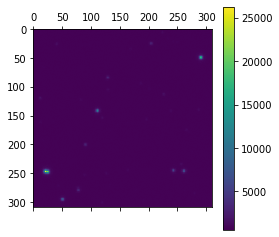

In [200]:
plt.matshow(test_image.cpu().numpy()[0, 0])
plt.colorbar()

# Get starnet map estimates

In [201]:
map_estimate = sleep_net.image_encoder.map_estimate(test_image.to(device), slen)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

(array([28., 11.,  4., 14.,  6.,  3.,  2.,  1.,  3.,  3.]),
 array([3.0345452, 3.3039846, 3.5734239, 3.842863 , 4.112303 , 4.381742 ,
        4.651181 , 4.9206204, 5.1900597, 5.4594994, 5.7289386],
       dtype=float32),
 <BarContainer object of 10 artists>)

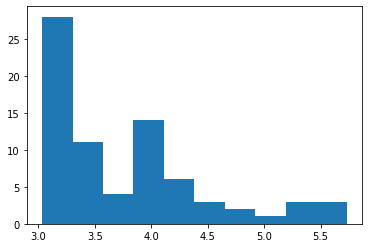

In [202]:
plt.hist(np.log10(map_estimate['fluxes'].squeeze().numpy()))

In [203]:
map_estimate['fluxes'].min()

tensor(1082.7924)

### Check the coverage

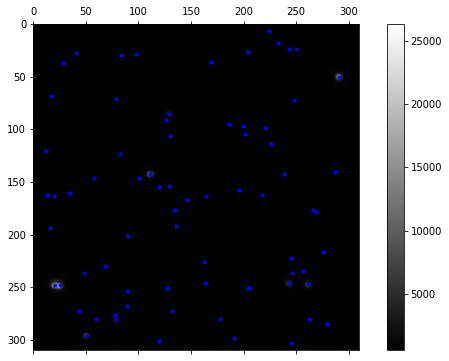

In [204]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

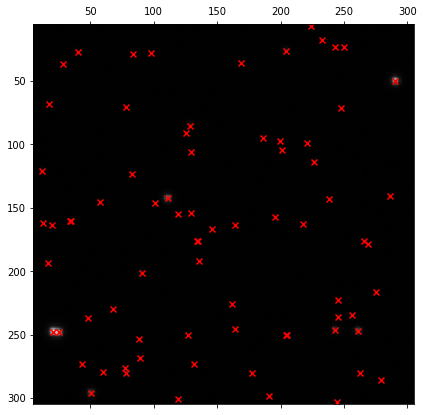

In [205]:
f, axarr = plt.subplots(1, 1, figsize=(8, 7))

plotting.plot_locations(
    map_estimate['locs'], 
    axarr,
    marker='x',
    color='r',
)


im = plotting.plot_image(axarr, 
                         image[0, 0], 
                         x1, 
                         x0,
                         slen,
                         slen)

f.colorbar(im, ax = ax)

In [206]:
# f, axarr = plt.subplots(1, 1, figsize=(4, 3))

# plotting.plot_locations(
#     map_estimate['locs'], 
#     axarr,
#     marker='x',
#     color='r',
# )

# # _x0 = 123
# # _x1 = 295
# _x0 = 236
# _x1 = 57

# subimage_slen = 20


# im = plotting.plot_image(axarr, 
#                          image[0, 0], 
#                          _x0, 
#                          _x1,
#                          subimage_slen,
#                          subimage_slen)

# f.colorbar(im, ax = axarr)

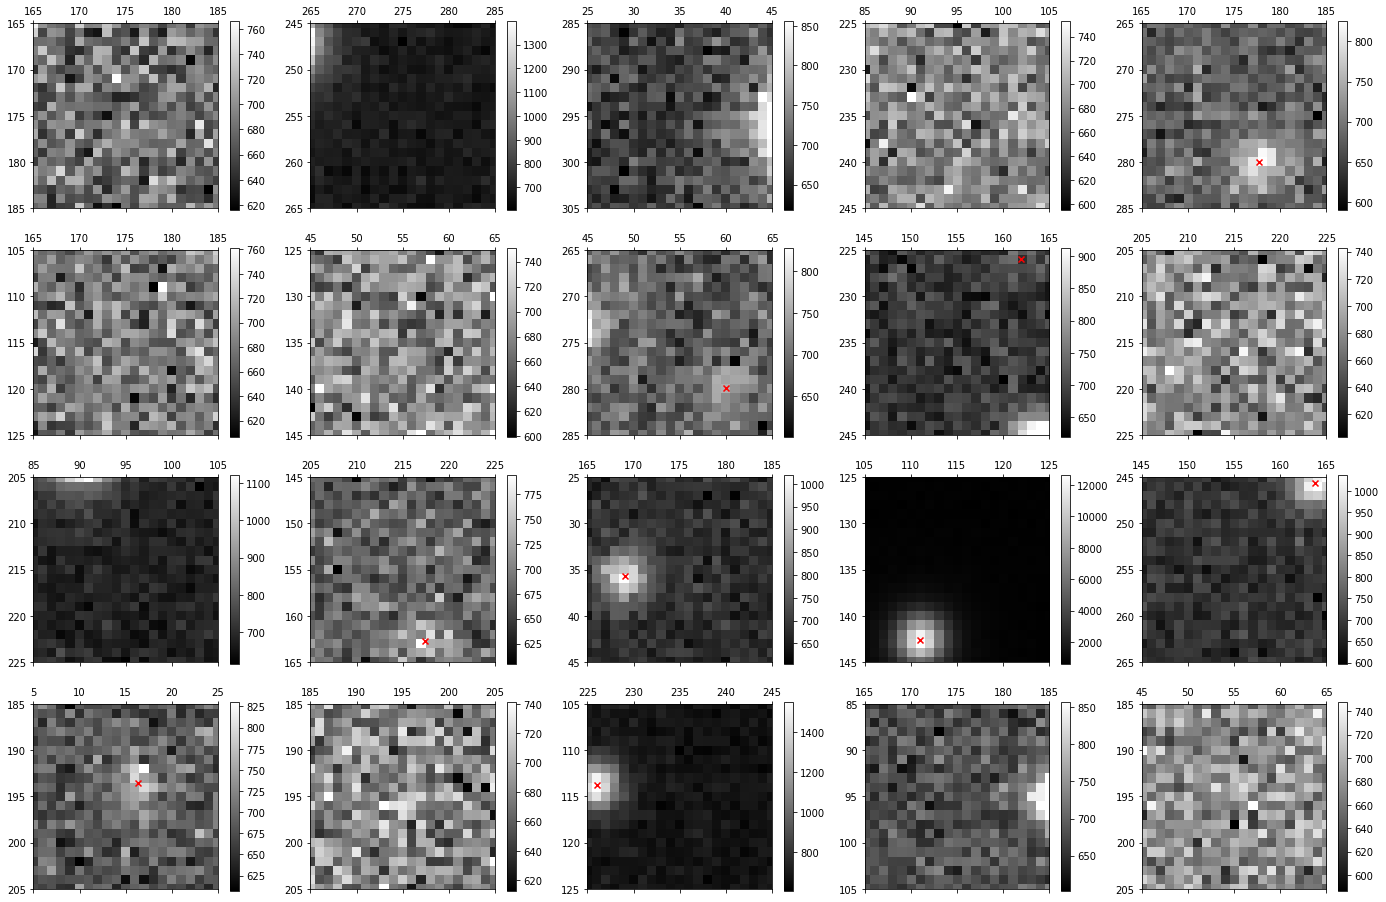

In [209]:
f, axarr = plt.subplots(4, 5, figsize=(24, 16))

subimage_slen = 20
x0_vec = np.arange(x0, x0 + slen, subimage_slen)
x1_vec = np.arange(x1, x1 + slen, subimage_slen)

for i in range(20): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)